In [7]:
library(sensitivity)
library(tidyr)
source("../augmented_utils.R")

parallel = TRUE
registerDoParallel(cores = 5)

# Preamble

### CtoR function to associate the best representatives to a given clustering

In [9]:
vec = seq(10^-10,1-10^-10,l=5000) #just a vector to estimate integral

try_unif_1d = function(samp, delta = NULL){ #this compute the optimal parameters of the 1D uniform
  quantiles_vec = quantile(samp, vec) #computation of the empirical quantile function on [0,1]
  if(is.null(delta)){ #if the width of the support is free
    u_bound = mean(quantiles_vec*(6*vec-2)) #estimate upper bound
    l_bound = mean(quantiles_vec*(-6*vec+4)) #estimate lower bound
  }
  else{ #if width of support is given
    l_bound = mean(quantiles_vec-delta/2) #estimate lower bound
    u_bound = l_bound+delta #estimate upper bound
  }
  return(matrix(c(l_bound, u_bound)))
  
}


CtoR = function(clusts, only_bornes = TRUE, n_sample = 500, return_error = FALSE){ #function that associate the best representative, either a dirac or a uniform on each marginal
  rep = list()
  law = list()
  local_errors = c() 
  for(j in 1:length(clusts)){ #for each cluster, the optimal representative will be provided
    mat = NULL
    law_j = c()
    diss_tot = 0 #quantization error
    for(k in 1:ncol(clusts[[j]])){ #for each marginal
     unif = try_unif_1d(clusts[[j]][,k], delta = 1) #get the uniform with given width = 1
     unif_tilde = from_law_to_sample(list(unif_prov), law = list("unif"), n = n_sample)[[1]] #get sample associated with this uniform
     diss_unif = wasserstein1d(unif_tilde_prov, clusts[[j]][,k],p=2) #compute wasserstein distance between the marginal and the uniform
       
     dirac = mean(clusts[[j]][,k]) #try dirac representative
     dirac = matrix(c(dirac, dirac)) 
     dirac_tilde = from_law_to_sample(list(dirac), law = list("dirac"), n = n_sample)[[1]]
     diss_dirac = wasserstein1d(dirac_tilde, clusts[[j]][,k],p=2) #compute wasserstein distance between the marginal and the dirac
     if(diss_dirac > diss_unif){ #if the dirac is not the best representative, keep uniform
      if(!only_bornes){mat = cbind(mat, unif_tilde)} #only_bornes=TRUE indicates that the only the parameters of the representatives are returned. If false, then a sample is returned for the representative
       else{mat = cbind(mat, unif)}
       law_j = c(law_j, "unif")
       diss_tot = diss_tot + diss_unif^2
     }
     else{ #if dirac is the best representative, save it
       if(!only_bornes){mat = cbind(mat, dirac_tilde)}
       else{mat = cbind(mat, dirac)}
       law_j = c(law_j, "dirac")
       diss_tot = diss_tot + diss_dirac^2
     }
    }
    rep[[j]] = mat
    law[[j]] = law_j
    local_errors = c(local_errors, sqrt(diss_tot))
  }
  res = list(rep, law)
  if(return_error){res = c(res,  list(local_errors, sapply(clusts, nrow)))}
  return(res)
}


### Function to initialize the AQ algorithm 

In [10]:

initialize_algo = function(l,d, multistart = 1){ #function to propose initial mixture (randomly selected)
    starts = list()
    for(start in 1:multistart){ #multistart
        weights = rep(1/l, l = l) #equal weights
        all_law = list()
        all_rep = list()
        for(xx in 1:l){
            size_unif = sample(x= c(0,1), size = d, replace = TRUE) #select uniform or dirac for each dimension (0 is dirac, 1 is uniform of width 1)
            repres = rbind(rep(0, d), rep(1,d))
            repres[1,size_unif < 0.5] = runif(sum(size_unif < 0.5))
            repres[2, size_unif < 0.5] = repres[1, size_unif < 0.5]
            law = rep("unif", d) 
            law[which(size_unif < 0.5)] = "dirac"
            all_rep[[xx]] = repres 
            all_law[[xx]] = law
        }
    starts[[start]] = list(rep = all_rep, law = all_law) 
    }
    return(starts)
}

### Definition of the G-function (Marrel et. al 2009) and computation of quantile

This function is defined as 

$$G(\mathbf{X}) \;=\; \prod_{i=1}^d \; \frac{\lvert 4X_i \;-\; 2\rvert \;+\; a_i}{1 + a_i}$$

where $X_i \in [0,1]$, $a_i \ge 0$, and $d$ is the dimension. Here we work with $d=10.$  

Why this function ? The coefficients $a_i$ control the impact of the variables:
- Small $a_i$ $\Rightarrow$ $X_i$ has big influence on $G$
- High $a_i$ $\Rightarrow$ $X_i$ has small influence on $G$

Here, we select 
- $a_i = 99$ for $i \in \{1,2,4,5,6,9,10\}$, rendering these variables non-influential.
- $a_3 = 0: $ biggest influence
- $a_7 = 2: $ relatively high influence
- $a_8 = 4: $ small influence

The objective is to perform AQ to identify the most influential variables on $G(\mathbf{X}) > q_{95}$, where $q_{95}$ is the $0.95$-quantile of $G(\mathbf{X}).$

In [17]:

gfunc <- function(xx, a = (seq_along(xx) - 1) / 2) {
  new1 <- abs(4 * xx - 2) + a
  new2 <- 1 + a 
  prod_term <- prod(new1 / new2)
  return(prod_term)
}

a = rep(99, 10) 
a[3] = 0
a[7] = 2
a[8] = 4
quant = 0.95

sob = sobol(10^6, dim = 10)
yy = apply(sob, 1, function(x){gfunc(x, a = a)})
q_095 <- round(as.numeric(quantile(yy, 0.95)), 2)
q_095



[1] 2.13

# Augmented Quantization

### Get conditionnal samples $F_1(X_1),..., F_{10}(X_{10}) \mid G(\mathbf{X}) > q_{95}$

In [18]:
set.seed(10)
X = as.data.frame(matrix(runif(n=6000*10, min =0, max = 1), ncol = 10))
yy = apply(X, 1, function(x){gfunc(x, a = a)})

Xsample = X[yy>q_095,]


### Run AQ algorithm

In [ ]:
set.seed(123)
init = initialize_algo(l = 4, d = 10)[[1]]
res_sensi = augmented_quanti(samp = as.matrix(Xsample), rep = init$rep,vec_prop = c(0.4,0.2,0.1), it_lim = 10,n_sample = 1000,threshold = 0.02, law = init$law, prop_search = 1)
save(res_sensi, file = "res_gfunc.RData")

### Plot obtained mixture

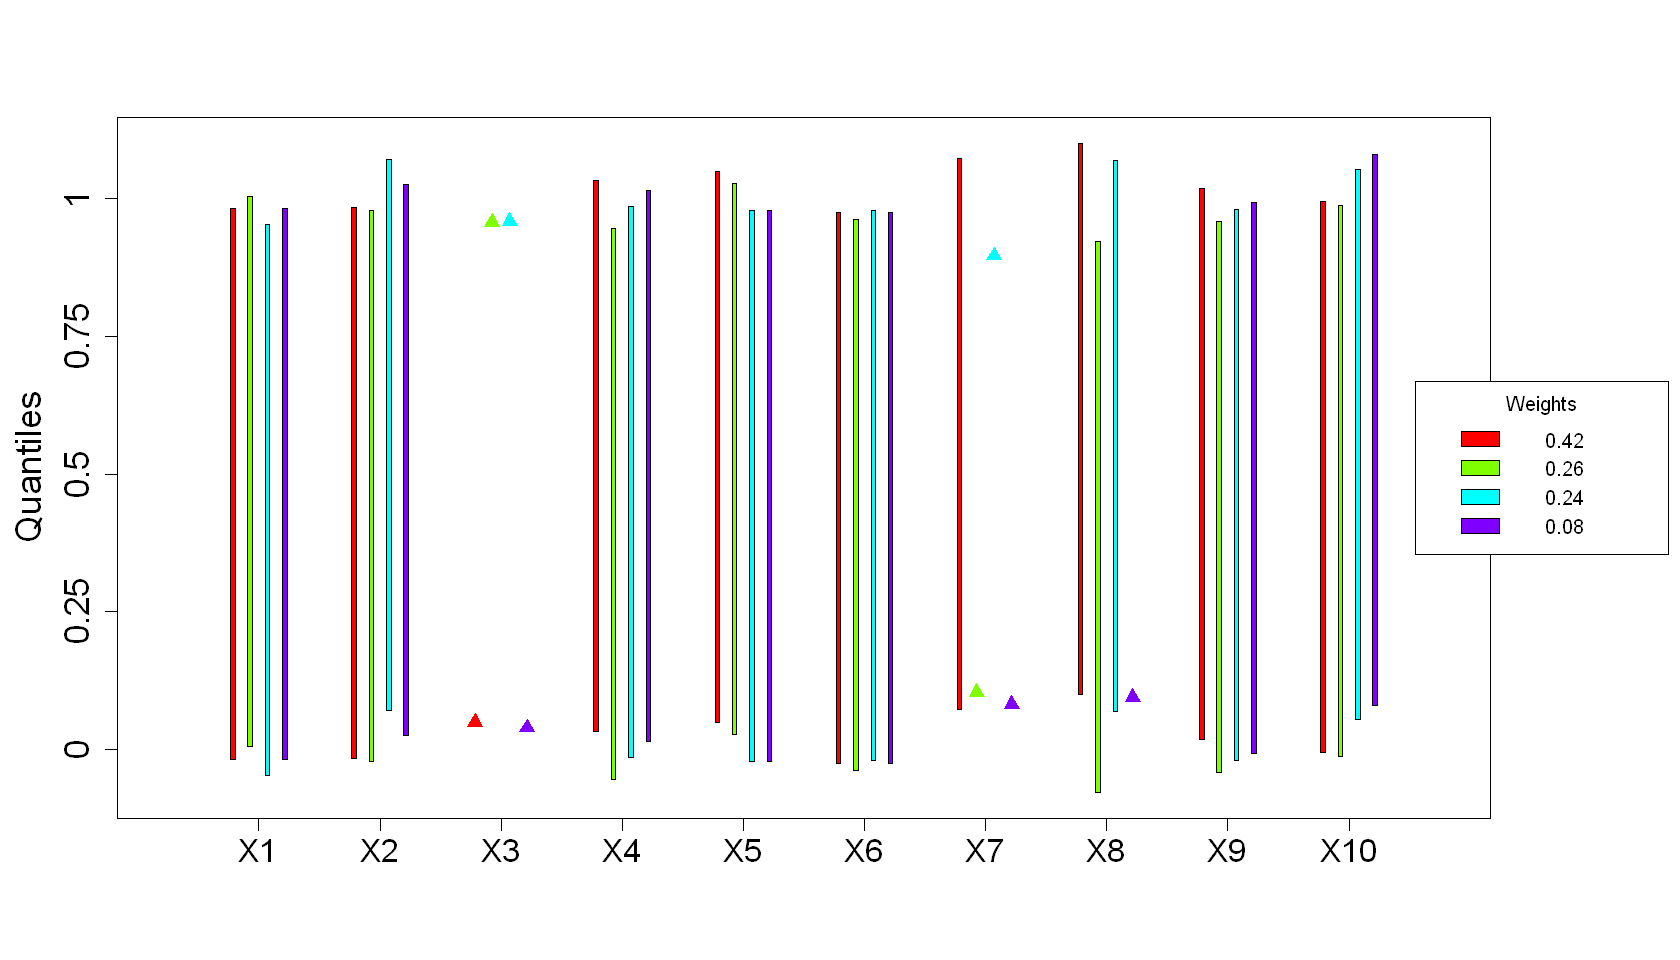

In [15]:
options(repr.plot.width = 14, repr.plot.height = 8)

load("res_gfunc.RData")
best_sensi = find_best(res_sensi)
df_plot = create_df_plot(best_sensi[[2]], best_sensi[[1]])
plot_hybrid_distrib(df_plot,c("X1","X2","X3", "X4", "X5", "X6","X7","X8","X9","X10"), cex_legend = 1, ysize = 1.7, inset = c(-0.13,0))

#plot_hybrid_distrib(df_plot,c("X1","X2","X3", "X4", "X5", "X6","X7","X8","X9","X10"), cex_legend = 1.3, ysize = 1.7, save = TRUE, save_name = "res_gfunc.pdf",inset = c(-0.05,0))

### Analysis

- For all variables $i \notin \{3,7,8\}$, the obtained mixture exhibits only large uniform representatives, indicating that these variables are non-influential, as expected.  
- For $X_3$, only Dirac representatives are identified, showing its strong influence on $G(\mathbf{X}) > q_{95}$.  
- Variable $X_7$ can take any value in $42\%$ of the scenarios (red representative), while only specific values of this variable lead to $Y > q_{95}$ in the remaining cases (Dirac for the three other representatives). This confirms that its influence is smaller than that of $X_3$, but still significant.  
- The influence of $X_8$ is highlighted in only $8\%$ of the cases (purple scenario), confirming that although it still has an effect, this effect is smaller than for $X_3$ and $X_7$.


# HSIC indices

### Function to compute HSIC indices 

In [79]:
func_hsic = function(it){
    X = as.data.frame(matrix(runif(n=6000*10, min = 0, max = 1), ncol = 10)) #sample X
    outputs =  apply(X, 1, function(x){gfunc(x, a = a)}) #output function
    return(sensiHSIC(model = function(X){return(outputs)}, X = X, target=list(c=q_095, type = "exp1side"))$S[[1]]) 
    }

### Compute the HSIC indices 

In [ ]:
set.seed(10)

n_iter = 200
results <- foreach(it = 1:n_iter, .combine = "rbind") %dopar% {
  func_hsic(it)
}
results = as.data.frame(results)
colnames(results) = c("X1","X2","X3", "X4", "X5", "X6","X7","X8","X9","X10")
write.csv(results, file = "results_hsic_gfunc.csv", row.names = FALSE)

### Plot the distributions of the HSIC indices

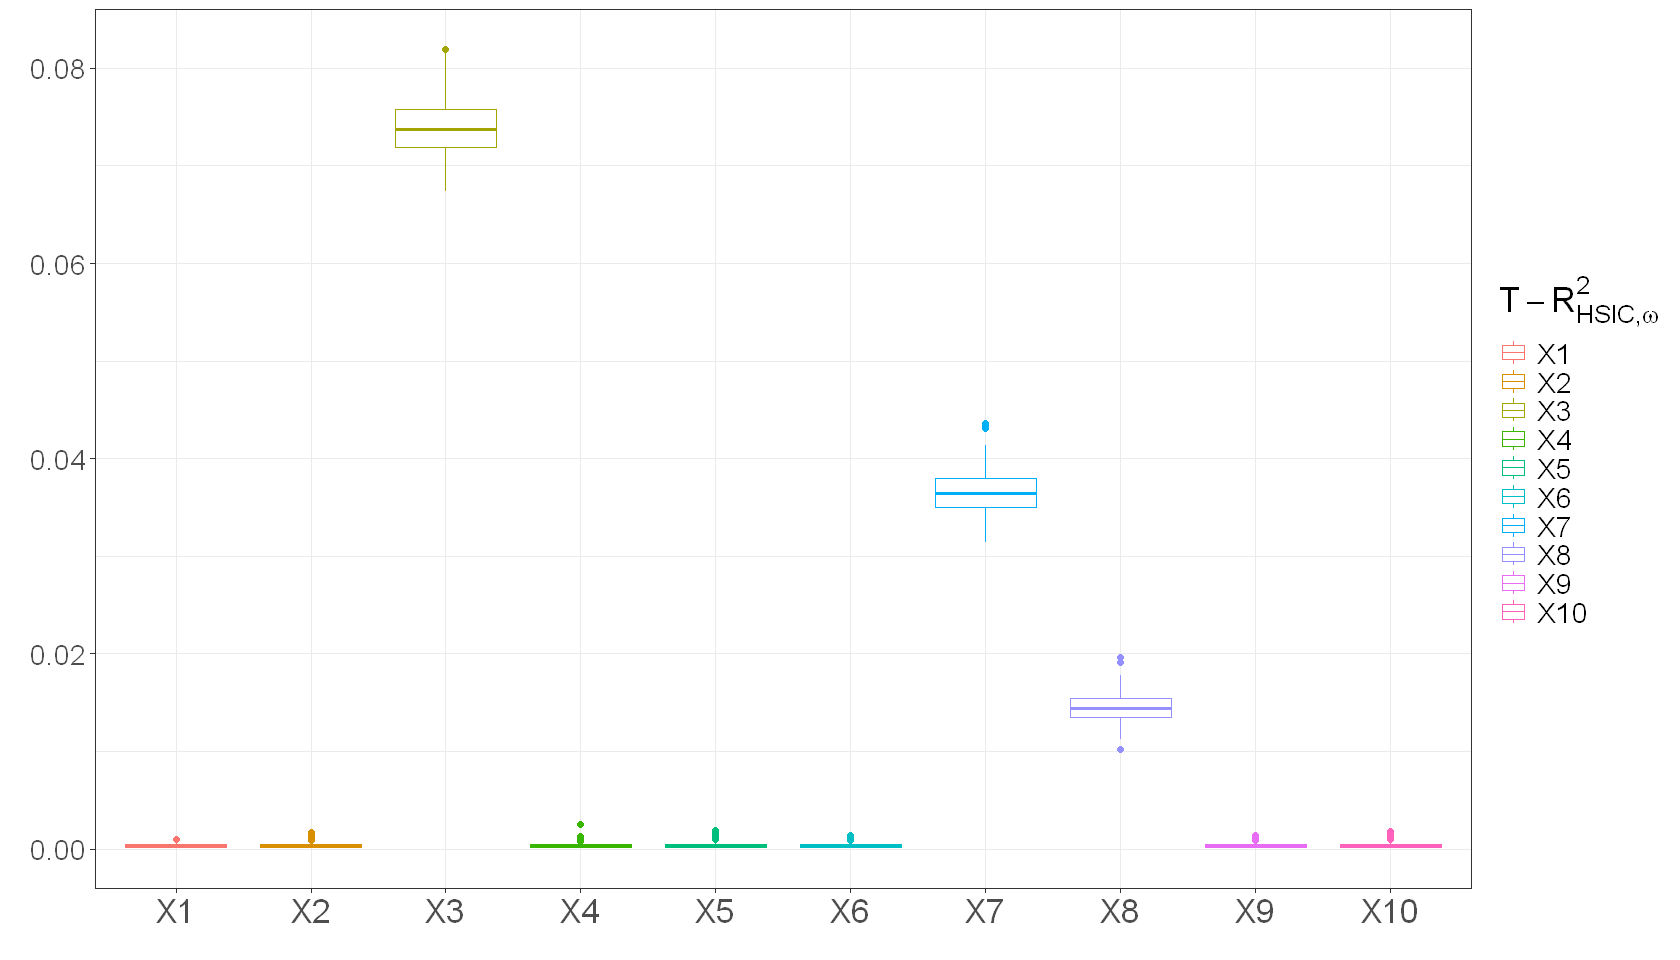

In [13]:
results = read.csv("results_hsic_gfunc.csv")
df_long <- pivot_longer(results, cols = everything(), names_to = "Variable", values_to = "Value")
df_long$Variable <- factor(df_long$Variable, levels = unique(df_long$Variable))

# Boxplots côte à côte
p = ggplot(df_long, aes(x = Variable, y = Value, col = Variable)) +
  geom_boxplot() +
  theme_bw() +
  labs(
    x = "", y = "",
    color = expression(T - R[phantom() * paste(plain("HSIC"), ",", omega)]^2)
  ) +
  scale_fill_brewer(palette = "Set2") +
  theme(
    legend.title = element_text(size = 21),  # taille du titre de la légende
    legend.text  = element_text(size = 17),  # taille du texte de la légende
    axis.text.x  = element_text(size = 20),  # taille des ticks en abscisse
    axis.text.y  = element_text(size = 17)   # taille des ticks en ordonnée
  )

p

In [14]:
#ggsave(filename = "hsic_gfunc.pdf",plot = p,device = cairo_pdf,width = 10, height = 7, units = "in",dpi = 600)

### Anlysis of HSIC indices

As expected from the construction of the function and confirmed by the AQ analysis, $x_3$, $x_7$, and $x_8$ are the only influential variables, in that order of influence.